## Some Visualizations for the Earth Mover's Distance
see [Wasserstein GAN and the Kantorovich-Rubinstein duality](https://vincentherrmann.github.io/blog/wasserstein/) and [最优传输 (Optimal transport) 和 sinkhorn 迭代](https://kaizhao.net/blog/optimal-transport)

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib import gridspec
import torch

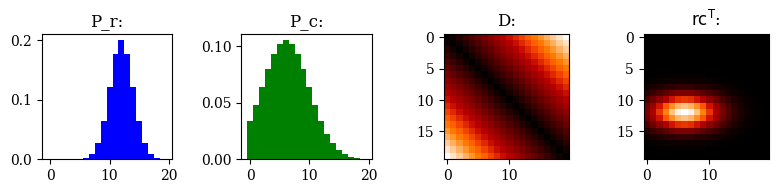

In [8]:
# 生成两个高斯分布数据分布
def gaussian(mean=0, std=10, n=100):
    d = (-((torch.arange(n) - mean) ** 2) / (2 * std**2)).exp()
    d /= d.sum()
    return d


l = 20
m = n = l
P_r = gaussian(mean=12, std=2, n=m)
P_c = gaussian(mean=6, std=4, n=n)

# dist = (torch.arange(m).view(1, m) - torch.arange(n).view(n, 1)).abs().float()
dist = (torch.arange(m).view(m, 1) - torch.arange(n).view(1, n)).abs().float()
D = dist / dist.max()
U = P_r.view(m, 1) * P_c.view(1, n)


P_r = P_r.cpu().numpy()
P_c = P_c.cpu().numpy()
D = D.cpu().numpy()
U = U.cpu().numpy()


# 画出分布以及它们的距离矩阵
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
axes[0].bar(range(m), P_r, 1, color="blue", alpha=1)
# axes[0].axis("off")
# axes[0].set_ylim(0, 0.5)
axes[0].set_title("P_r:")

axes[1].bar(range(n), P_c, 1, color="green", alpha=1)
# axes[1].axis("off")
# axes[1].set_ylim(0, 0.5)
axes[1].set_title("P_c:")

axes[2].imshow(D, cmap=cm.gist_heat, interpolation="nearest")
# axes[2].axis("off")
axes[2].set_title("D:")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
axes[3].imshow(U, cmap=cm.gist_heat, interpolation="nearest")
# axes[2].axis("off")
axes[3].set_title(r"$\mathrm {rc^T}$:")
plt.rc('text', usetex=False)
fig.tight_layout()
plt.show()

In [9]:
from scipy.optimize import linprog

# 使用线性规划求解EMD距离
A_r = np.zeros((m, m, m))
A_t = np.zeros((n, n, n))

for i in range(m):
    for j in range(n):
        A_r[i, i, j] = 1
        A_t[i, j, i] = 1

A = np.concatenate((A_r.reshape((m, m**2)), A_t.reshape((n, n**2))), axis=0)  # 20x100
b = np.concatenate((P_r, P_c), axis=0)  # (20,)
c = D.reshape((m * n))  # (100,)

opt_res = linprog(c, A_eq=A, b_eq=b, bounds=[0, None])
emd = opt_res.fun
gamma = opt_res.x.reshape((m, n))
print("EMD: ", emd, "\n")

EMD:  0.29249998706370883 



sinkhorn distance

In [10]:
def sinkhorn_distance(r, c, M, reg=1e-2, error_thres=1e-5, niter=100):
    """
    # from https://github.com/gabsens/Learning-Embeddings-into-Entropic-Wasserstein-Spaces-ENSAE/blob/master/Notebook.ipynb,
    # https://github.com/vlkit/vlkit/blob/main/vlkit/optimal_transport/sinkhorn.py
    Args:
        r (torch.tensor): tensor with shape (b, m), the first distribution .
        c (torch.tensor): tensor with shape (b, n), the second distribution.
        M (torch.tensor): tensor with shape (b, m, ) the ground metric.
        reg (float): factor for entropy regularization (corresponds to \frac{1}{\lambda} in [1]).
        error_thres (float): the error threshold to stop the iteration.
        num_iters (int): number of total iterations.

    Returns:
        torch.tensor: the optimal transportation matrix (b, m, n).
    """
    device = r.device

    b, m, n = M.shape
    assert r.shape[0] == c.shape[0] == b and r.shape[1] == m and c.shape[1] == n, "r.shape=%s, c=shape=%s, M.shape=%s" % (r.shape, c.shape, M.shape)

    K = (-M / reg).exp()  # (b, m, n)
    u = torch.ones_like(r) / m  # (b, m)
    torch_1 = torch.ones((b, 1), device=device).detach()
    K_ = (K / r.unsqueeze(-1)).detach()

    for _ in range(niter):
        r0 = u
        v = c / torch.einsum("bmn,bm->bn", [K, u])  # (b, n)
        u = torch_1 / (torch.einsum("bmn,bn->bm", [K_, v]))

        err = (u - r0).abs().mean()
        if err.item() < error_thres:
            break
    T = torch.einsum("ij,ik->ijk", [u, v]) * K
    return T


_r = torch.from_numpy(P_r).float().unsqueeze(0)  # b, m
_c = torch.from_numpy(P_c).float().unsqueeze(0)  # b, n
_M = torch.from_numpy(D).float().unsqueeze(0)  # b, m, n
P = sinkhorn_distance(_r, _c, _M,reg=1e-2)
P = P.squeeze(0).cpu().numpy()
sinkhorn_d = np.sum(P * D)

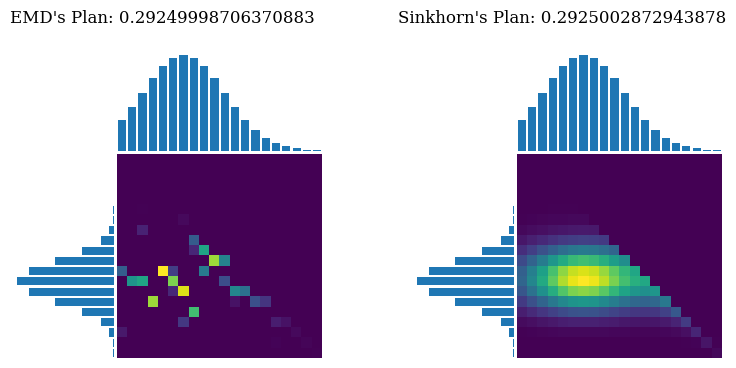

In [11]:
# 画出两个plan
Plans = [gamma, P]
titles = [f"EMD's Plan: {emd}", f"Sinkhorn's Plan: {sinkhorn_d}"]

fig = plt.figure(figsize=(8, 4))
# gses = gridspec.GridSpec(3, 6,wspace=0.03, hspace=0.05)
gses = gridspec.GridSpec(1, 2, wspace=0.03, hspace=0.05)


def draw(T, fig):
    gs = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, wspace=0.03, hspace=0.03)
    ax1 = fig.add_subplot(gs[0, 1:3])
    ax1.axis("off")
    ax1.bar(torch.arange(n), P_c, label="Target distribution")

    ax2 = fig.add_subplot(gs[1:, 0])
    ax2.axis("off")
    ax2.barh(torch.arange(m), P_r, label="Source distribution")

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    ax3 = fig.add_subplot(gs[1:3, 1:3], sharex=ax1, sharey=ax2)
    ax3.imshow(T)
    ax3.axis("off")


for i, _P in enumerate(Plans):
    # gs = gses[i].subgridspec(3, 3,wspace=0.03, hspace=0.05)
    subfigure = fig.add_subfigure(gses[i])
    subfigure.suptitle(titles[i])
    draw(_P, subfigure)

plt.show()

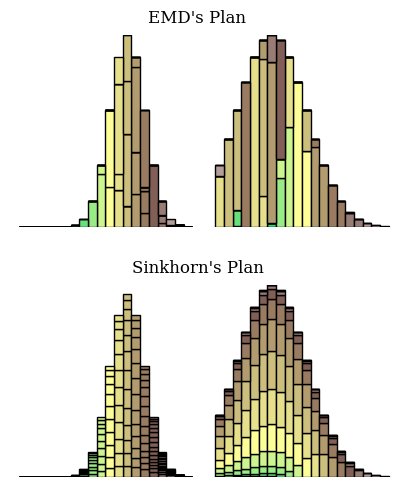

In [12]:
# 画出两个分布的变化情况
cNorm = colors.Normalize(vmin=0, vmax=m)
colorMap = cm.ScalarMappable(norm=cNorm, cmap=cm.terrain)

Plans = [gamma, P]
titles = ["EMD's Plan", "Sinkhorn's Plan"]

fig = plt.figure(figsize=(5, 5))
gses = gridspec.GridSpec(2, 1, wspace=0.03, hspace=0.05)


def draw(_P, fig):
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.03, hspace=0.03)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    current_bottom = np.zeros(m)
    r = range(m)
    for i in r.__reversed__():
        ax1.bar(r, _P[r, i], 1, color=colorMap.to_rgba(r), bottom=current_bottom, edgecolor="black")
        current_bottom = current_bottom + _P[r, i]
    ax1.axis("off")

    new_current_bottom = np.zeros(m)
    r = range(m)
    for i in r:
        ax2.bar(r, _P[i, r], 1, color=colorMap.to_rgba(i), bottom=new_current_bottom, edgecolor="black")
        new_current_bottom = new_current_bottom + _P[i, r]
    ax2.axis("off")


for i, _P in enumerate(Plans):
    subfigure = fig.add_subfigure(gses[i])
    subfigure.suptitle(titles[i])
    draw(_P, subfigure)


# fig.tight_layout()
plt.show()